# Importing Data

In [1]:
%%bash
pip install gdown
if [ ! -f census_income.zip ]; then
    gdown 1-PECcHuWo6wO3g6xbR2sOLOyoCWshfLS
fi
unzip -n census_income.zip

Couldn't find program: 'bash'


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.functions import vector_to_array

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
text_rdd = spark.sparkContext.textFile('adult100k')
text_rdd_cleaned = text_rdd.map(lambda x: tuple(x.split(',')))

In [4]:
schema = StructType([
    StructField("Age", StringType(), True),  
    StructField("WorkClass", StringType(), True),
    StructField("Fnlwgt", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("EducationNum", StringType(), True),
    StructField("MaritalStatus", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Relationship", StringType(), True),
    StructField("Race", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("CapitalGain", StringType(), True),
    StructField("CapitalLoss", StringType(), True),
    StructField("HoursPerWeek", StringType(), True),
    StructField("NativeCountry", StringType(), True),
    StructField("Income", StringType(), True)
])

spark_dataframe = spark.createDataFrame(text_rdd_cleaned, schema)

In [5]:
spark_dataframe.show(5)

+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|Age|       WorkClass|Fnlwgt|Education|EducationNum|     MaritalStatus|       Occupation| Relationship| Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
| 39|       State-gov| 77516|Bachelors|          13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|       2174|          0|          40|United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|          13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|          0|          0|          13|United-States| <=50K|
| 38|         Private|215646|  HS-grad|           9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|         

# Data Exploration 

In [6]:
# How many records in this dataframe? 
num_records = spark_dataframe.count()
print('Number of records:', num_records)

Number of records: 100000


In [7]:
# Data Type Handling 
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for col_name in NumericalDataType:
    spark_dataframe = spark_dataframe.withColumn(col_name, col(col_name).cast('float'))

In [8]:
# Missing Data / Imputations 
null_counts = spark_dataframe.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spark_dataframe.columns))
null_counts.show()

+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|Age|WorkClass|Fnlwgt|Education|EducationNum|MaritalStatus|Occupation|Relationship|Race|Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|  0|        0|     0|        0|           0|            0|         0|           0|   0|  0|          0|          0|           0|            0|     0|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+



In [9]:
# Describe the Data
spark_dataframe.describe()

DataFrame[summary: string, Age: string, WorkClass: string, Fnlwgt: string, Education: string, EducationNum: string, MaritalStatus: string, Occupation: string, Relationship: string, Race: string, Sex: string, CapitalGain: string, CapitalLoss: string, HoursPerWeek: string, NativeCountry: string, Income: string]

### Column Descriptions 
- Age : Age of person in years (Numerical)
- WorkClass : Type of work that the person does (Catergorical)
- Fnlwgt : Final weight is the number of people the census believes the entry represents. (Numerical)
- Education : Highest Level of Education (Catergorical)
- EducationNum : Number of years completed of education (Numerical) 
- MaritalStatus : Marital status of the person (Catergorical)
- Occupation : Person's profession (Catergorical) 
- Relationship : Familial status of the person (Catergorical)
- Race : Race of person (Catergorical)
- Sex : Sex of person (Catergorical)
- CapitalGain : Capital gains for an individual (Numerical)
- CapitalLoss :  Capital loss for an individual (Numerical)
- HoursPerWeek : Hours per week that the person works (Numerical) 
- NativeCountry : Country of origin for an individual (Catergorical) 
- Income : Whether or not the person makes over or under $50k (Catergorical) 

## Data Visualization

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

### Numerical Variables

In [11]:
numerical_columns = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

In [12]:
pandas_df = spark_dataframe.select(numerical_columns).toPandas()

In [13]:
# Display basic statistics of numerical columns
print("Basic Statistics of Numerical Columns:")
print(pandas_df.describe())

Basic Statistics of Numerical Columns:
                 Age        Fnlwgt   EducationNum    CapitalGain  \
count  100000.000000  1.000000e+05  100000.000000  100000.000000   
mean       48.365822  1.938729e+05       9.020150    4952.933594   
std        20.161259  1.101910e+05       4.133853   10390.030273   
min        17.000000  1.228500e+04       1.000000       0.000000   
25%        31.000000  1.175830e+05       6.000000       0.000000   
50%        46.000000  1.812820e+05       9.000000    2407.000000   
75%        64.000000  2.459180e+05      13.000000    5013.000000   
max        90.000000  1.484705e+06      16.000000   99999.000000   

         CapitalLoss   HoursPerWeek  
count  100000.000000  100000.000000  
mean     1302.040283      45.919090  
std      1063.387817      24.701674  
min         0.000000       1.000000  
25%         0.000000      30.000000  
50%      1602.000000      40.000000  
75%      2129.000000      61.000000  
max      4356.000000      99.000000  


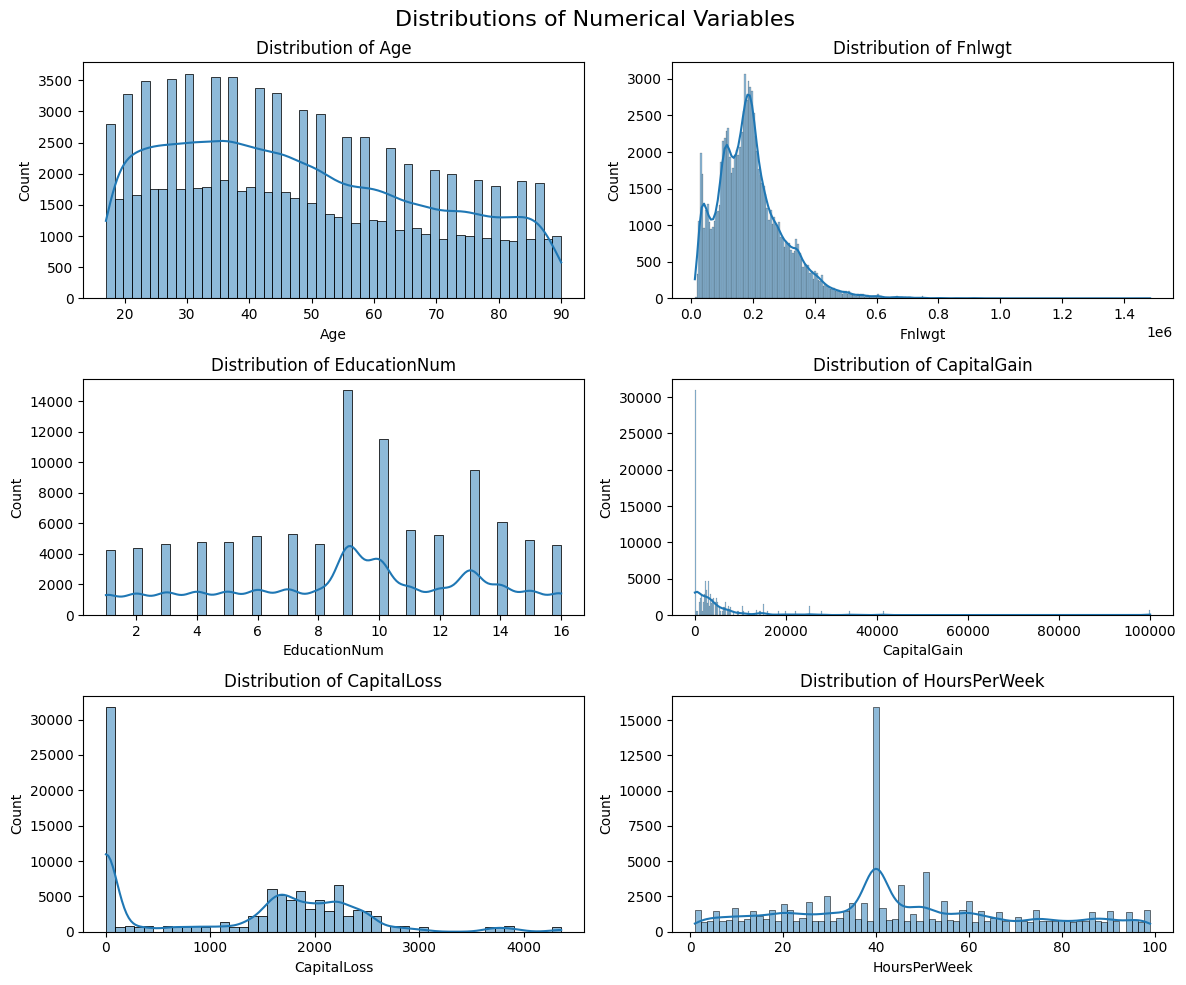

In [14]:
# Visualize the distribution of numerical columns in a 3 by 2 grid layout
plt.figure(figsize=(12, 10))
plt.suptitle("Distributions of Numerical Variables", fontsize=16)  # Title of the overall plot

for i, column in enumerate(pandas_df[numerical_columns]):
    plt.subplot(3, 2, i + 1)
    sns.histplot(pandas_df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

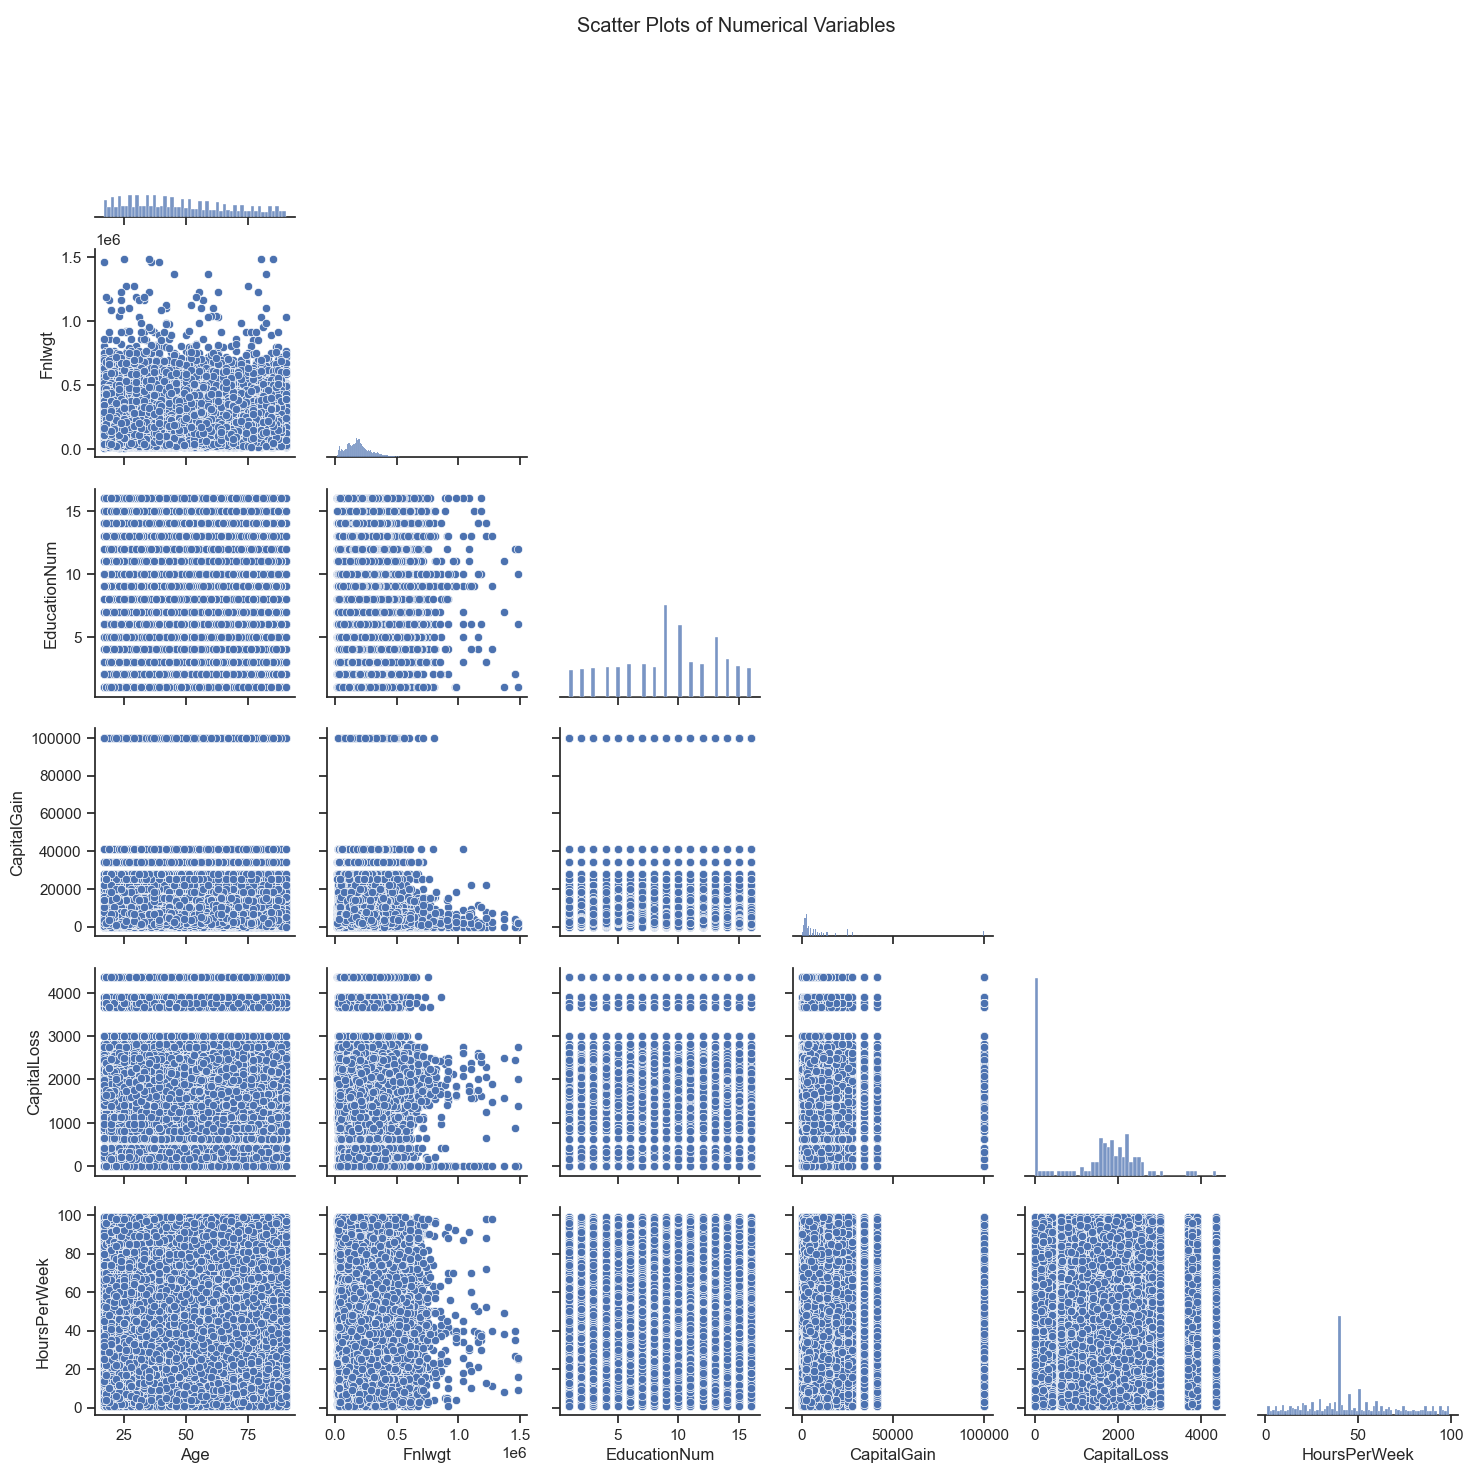

In [15]:
#Pairplot showing the scatter plots and relationships between Numerical Variables 
sns.set(style="ticks")

pp=sns.pairplot(pandas_df, corner='true' )
pp.fig.suptitle("Scatter Plots of Numerical Variables")
plt.show()

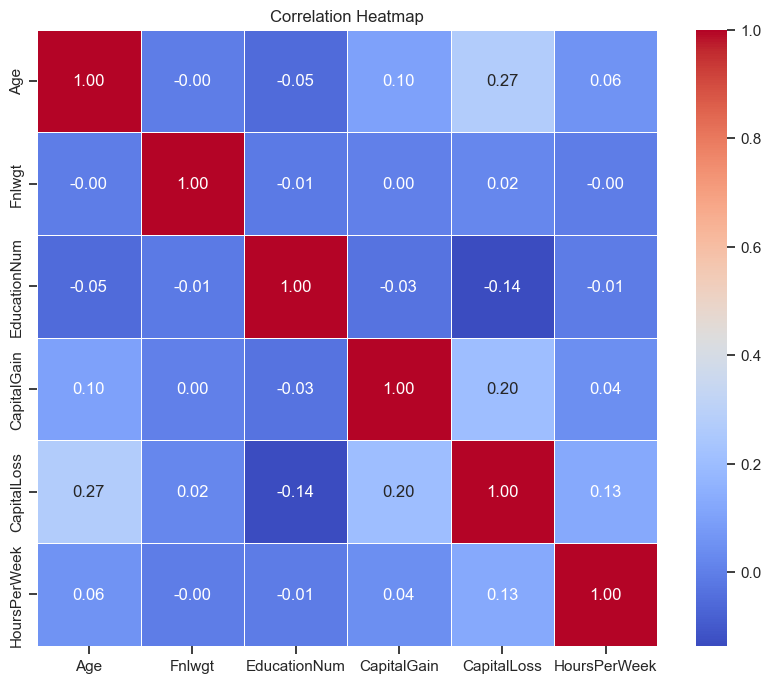

In [16]:
# Compute the correlation matrix
corr_matrix = pandas_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 12})
plt.title('Correlation Heatmap')
plt.show()

### Categorical Variables

In [17]:
categorical_columns = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Sex', 'Income']
categorical_columns2 = ['NativeCountry']

C:\Users\Allison Conrey\AppData\Local\Temp\ipykernel_5216\813216910.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_bottom = plt.subplot2grid((5, 2), (4, 0), colspan=2)


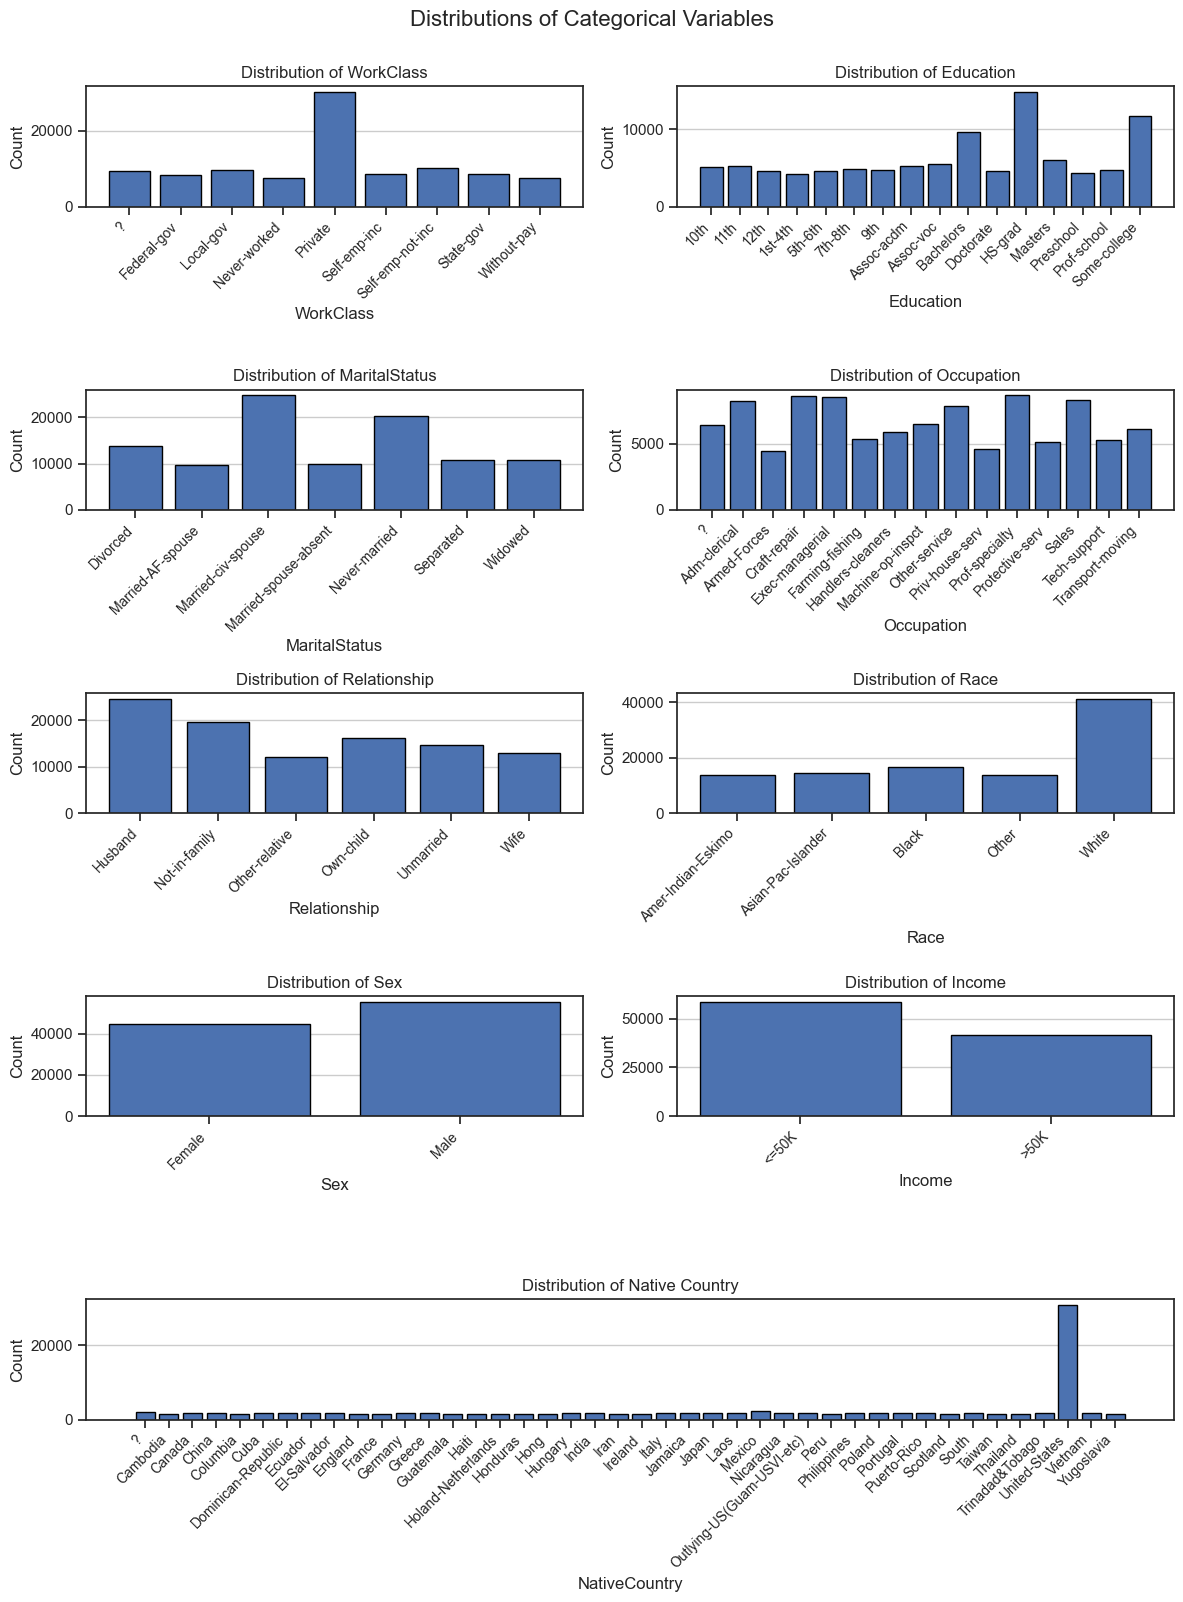

In [18]:
# Create subplots with a 4x2 grid for the categorical columns
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle("Distributions of Categorical Variables", fontsize=16, y=1)

# Plot bar plots for each categorical column
for i, column in enumerate(categorical_columns):
    counts = spark_dataframe.groupBy(column).count().orderBy(column).collect()
    categories = [str(row[column]) for row in counts]
    values = [row['count'] for row in counts]
    
    # Access the individual axes correctly
    ax = axes[i // 2, i % 2]
    ax.bar(categories, values, edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.grid(axis='y')
    
    # Set ticks and then rotate x-axis labels by 45 degrees and increase font size
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)

# Plot bar plot for NativeCountry separately
counts2 = spark_dataframe.groupBy('NativeCountry').count().orderBy('NativeCountry').collect()
categories2 = [str(row['NativeCountry']) for row in counts2]
values2 = [row['count'] for row in counts2]

# Add a long horizontal graph at the bottom for NativeCountry
ax_bottom = plt.subplot2grid((5, 2), (4, 0), colspan=2)
ax_bottom.bar(categories2, values2, edgecolor='black')
ax_bottom.set_title('Distribution of Native Country')
ax_bottom.set_xlabel('NativeCountry')
ax_bottom.set_ylabel('Count')
ax_bottom.grid(axis='y')
ax_bottom.set_xticks(range(len(categories2)))
ax_bottom.set_xticklabels(categories2, rotation=45, ha='right', fontsize=10)

# Hide the empty subplots behind ax_bottom
for ax in axes[-1]:
    ax.set_visible(False)

# Adjust padding between subplots
plt.subplots_adjust(hspace=2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Response Variables

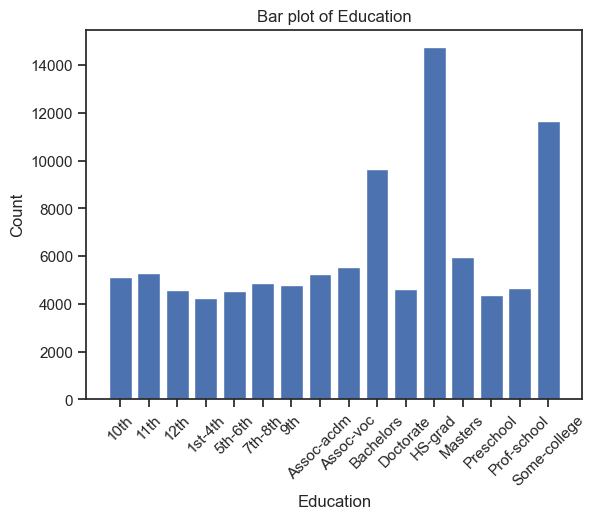

In [19]:
for i in ['Education']:
    value_counts = spark_dataframe.groupBy(i).count().orderBy(i).collect()

    values = [row[i] for row in value_counts]
    frequencies = [row['count'] for row in value_counts]

    plt.bar(values, frequencies)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title('Bar plot of {}'.format(i))
    plt.xticks(rotation=45)
    plt.show()

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a function to map education levels to groups
def group_education_level(education_label):
    education_index_mapping = {
        'HS-grad': 'High School or GED',
        'Some-college': 'Some College',
        'Bachelors': "Bachelor's Degree",
        'Masters': "Master's Degree",
        'Assoc-voc': "Associate's Degree",
        '11th': 'Less than High School',
        'Assoc-acdm': "Associate's Degree",
        '10th': 'Less than High School',
        '7th-8th': 'Less than High School',
        '9th': 'Less than High School',
        'Prof-school': "Master's Degree",
        '12th': 'Less than High School',
        'Doctorate': 'Doctorate',
        '5th-6th': 'Less than High School',
        'Preschool': 'Less than High School',
        '1st-4th': 'Less than High School'
    }
    return education_index_mapping.get(education_label, 'Other')

# Define a UDF to apply the function to each row of the DataFrame
group_education_udf = udf(group_education_level, StringType())

# Apply the UDF to create a new column for grouped education levels
spark_dataframe_with_grouped_education = spark_dataframe.withColumn('EducationGroup', group_education_udf(spark_dataframe['Education']))

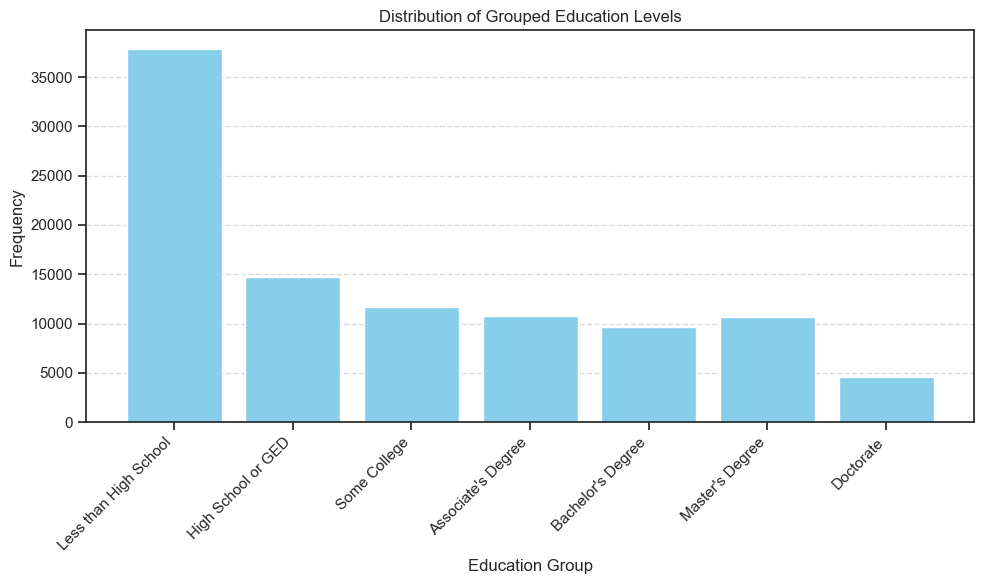

In [21]:
# Count the frequency of each education group
education_group_counts = spark_dataframe_with_grouped_education.groupBy('EducationGroup').count().toPandas()

# Define the order of education groups from least education to most education
education_order = [
    'Less than High School',
    'High School or GED',
    'Some College',
    "Associate's Degree",
    "Bachelor's Degree",
    "Master's Degree",
    'Doctorate',
    'Other'
]

# Filter only the existing education groups before reordering
existing_education_groups = [group for group in education_order if group in education_group_counts['EducationGroup'].values]

# Reorder the education_group_counts DataFrame based on the filtered order
education_group_counts = education_group_counts.set_index('EducationGroup').loc[existing_education_groups].reset_index()

# Plot the distribution of education groups
plt.figure(figsize=(10, 6))
plt.bar(education_group_counts['EducationGroup'], education_group_counts['count'], color='skyblue')
plt.title('Distribution of Grouped Education Levels')
plt.xlabel('Education Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [22]:
spark_dataframe_with_grouped_education = spark_dataframe_with_grouped_education.drop('Education')

In [23]:
# Print the schema of the DataFrame to check for the presence of the 'EducationGroup' column
spark_dataframe_with_grouped_education.printSchema()

root
 |-- Age: float (nullable = true)
 |-- WorkClass: string (nullable = true)
 |-- Fnlwgt: float (nullable = true)
 |-- EducationNum: float (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Relationship: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- CapitalGain: float (nullable = true)
 |-- CapitalLoss: float (nullable = true)
 |-- HoursPerWeek: float (nullable = true)
 |-- NativeCountry: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- EducationGroup: string (nullable = true)



# Data Preprocessing

- Numerical variables have been composed into a vector in `NumericalDataType` column
- Dataset has been split to train, test and validation set in proportions: 60/20/20
- Numerical variables vector have been scaled using `StandardScaler` to better represent normal distribution
- Categorical variables have been converted into their numerical representation
- Dataframes have been filtered to contain only transformed columnsumns

In [24]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import ArrayType, DoubleType


In [25]:
list_of_columns = list(spark_dataframe_with_grouped_education.columns)
CatergoricalDataType = [el for el in list_of_columns if el not in NumericalDataType]


In [26]:
vector_assembler = VectorAssembler().setInputCols(NumericalDataType).setOutputCol('NumericalDataType')
spark_dataframe_transformed = vector_assembler.transform(spark_dataframe_with_grouped_education)
train_split, test_split, validation_split = spark_dataframe_transformed.randomSplit([0.6, 0.2, 0.2], seed=13)

def flatten(df):
    return df.withColumn("NumericalDataTypeTransformed", vector_to_array(F.col('NumericalDataTypeTransformed'))) \
        .select(CatergoricalDataType + [F.col("NumericalDataTypeTransformed")[i].alias(c + "Scaled") for i, c in enumerate(NumericalDataType)])

scaler_model = StandardScaler().setInputCol('NumericalDataType').setOutputCol('NumericalDataTypeTransformed').fit(train_split)
scaled_train = flatten(scaler_model.transform(train_split))
scaled_test = flatten(scaler_model.transform(test_split))
scaled_validation = flatten(scaler_model.transform(validation_split))

scaled_train.show(5)

+---------+-------------+-----------------+--------------+------------------+------+-------------+------+--------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+
|WorkClass|MaritalStatus|       Occupation|  Relationship|              Race|   Sex|NativeCountry|Income|      EducationGroup|         AgeScaled|       FnlwgtScaled|EducationNumScaled|  CapitalGainScaled| CapitalLossScaled|HoursPerWeekScaled|
+---------+-------------+-----------------+--------------+------------------+------+-------------+------+--------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+
|        ?|Never-married|                ?|     Own-child|             White|  Male|United-States| <=50K|Less than High Sc...|0.8437775944574365| 0.3082396638183189|1.4525343911957913|                0.0|               0.0|0.8112654554332142|
|        ?|Never-married|   

In [27]:
string_indexer = StringIndexer(inputCols=CatergoricalDataType, outputCols=[el + "Indexed" for el in CatergoricalDataType])
indexer_model = string_indexer.fit(train_split)
indexed_train = indexer_model.transform(scaled_train)
indexed_test = indexer_model.transform(scaled_test)
indexed_validation = indexer_model.transform(scaled_validation)

indexed_train.show(5)

+---------+-------------+-----------------+--------------+------------------+------+-------------+------+--------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+---------------------+
|WorkClass|MaritalStatus|       Occupation|  Relationship|              Race|   Sex|NativeCountry|Income|      EducationGroup|         AgeScaled|       FnlwgtScaled|EducationNumScaled|  CapitalGainScaled| CapitalLossScaled|HoursPerWeekScaled|WorkClassIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|EducationGroupIndexed|
+---------+-------------+-----------------+--------------+------------------+------+-------------+------+--------------------+------------------+-------------------+------------------+------------------

In [28]:
preprocessed_columns = [el + "Indexed" for el in CatergoricalDataType] + [el + "Scaled" for el in NumericalDataType]
train = indexed_train.select(preprocessed_columns)
test = indexed_test.select(preprocessed_columns)
validation = indexed_validation.select(preprocessed_columns)

train.show(5)

+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+---------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+
|WorkClassIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|EducationGroupIndexed|         AgeScaled|       FnlwgtScaled|EducationNumScaled|  CapitalGainScaled| CapitalLossScaled|HoursPerWeekScaled|
+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+---------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+
|             3.0|                 1.0|              7.0|                2.0|        0.0|       0.0|                 0.0|          0.0|                  0.0|0.8437775944574365| 0

In [29]:
# Features (X) for train, test, and validation
feature_columns = [col for col in preprocessed_columns if col != 'EducationGroupIndexed']
label_column = 'EducationGroupIndexed'

In [30]:
education_indexer_model = indexer_model 

# Retrieve the index mapping labels for the 'EducationGroup' column
educationgroup_mapping = education_indexer_model.labelsArray[8]  # 'Education' is the ninth indexed column

# Print the index mapping for the 'EducationGroup' column
print("Index mapping for 'EducationGroup' column:")
for index, label in enumerate(educationgroup_mapping):
    print(f"Index: {index} --> Label: {label}")


Index mapping for 'EducationGroup' column:
Index: 0 --> Label: Less than High School
Index: 1 --> Label: High School or GED
Index: 2 --> Label: Some College
Index: 3 --> Label: Associate's Degree
Index: 4 --> Label: Master's Degree
Index: 5 --> Label: Bachelor's Degree
Index: 6 --> Label: Doctorate


# MODELS

## Logistic Regression Model

In [31]:
# Define VectorAssembler to assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Create Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol=label_column)

# Create a pipeline with VectorAssembler and Logistic Regression model
pipeline = Pipeline(stages=[vector_assembler, lr])


In [32]:
# Define the parameter grid to search
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [100, 200, 500]) \
    .addGrid(lr.tol, [1e-4, 1e-3, 1e-2]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

In [33]:

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="EducationGroupIndexed", metricName="accuracy")

In [34]:
# Create CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 5-fold cross-validation

# Fit the cross-validated model to the training data
cvModel = crossval.fit(train)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Print the best model parameters
print(f"Best regParam: {bestModel.stages[-1]._java_obj.getRegParam()}")
print(f"Best elasticNetParam: {bestModel.stages[-1]._java_obj.getElasticNetParam()}")
print(f"Best maxIter: {bestModel.stages[-1]._java_obj.getMaxIter()}")
print(f"Best tol: {bestModel.stages[-1]._java_obj.getTol()}")
print(f"Best fitIntercept: {bestModel.stages[-1]._java_obj.getFitIntercept()}")

Best regParam: 0.01
Best elasticNetParam: 0.0
Best maxIter: 100
Best tol: 0.001
Best fitIntercept: False


In [35]:
# Compute accuracy for training set
train_predictions = bestModel.transform(train)
train_accuracy = evaluator.evaluate(train_predictions)

# Compute accuracy for validation set
validation_predictions = bestModel.transform(validation)
validation_accuracy = evaluator.evaluate(validation_predictions)

# Evaluate the best model on the test data
test_predictions = bestModel.transform(test)
test_accuracy = evaluator.evaluate(test_predictions)

# Print accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.4562667867807751
Validation Accuracy: 0.46342445753410866
Test Accuracy: 0.4504308210359513


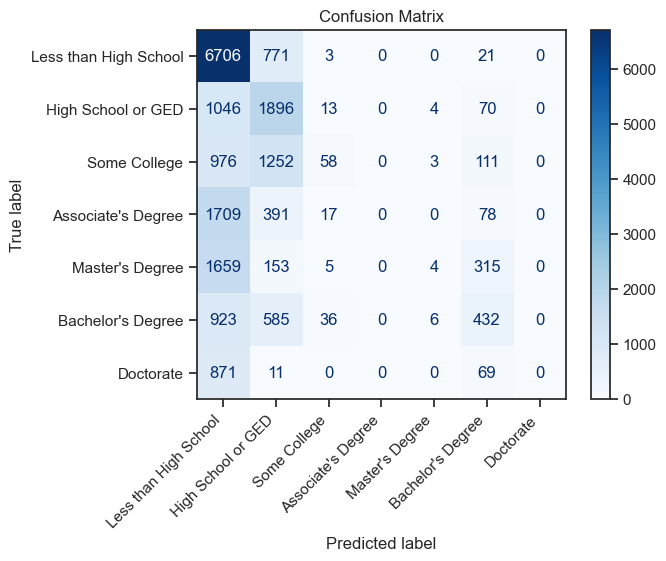

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract true labels and predictions from test set
y_true = np.array(test.select(label_column).collect()).ravel()
y_pred = np.array(test_predictions.select("prediction").collect()).ravel()

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define the education labels
education_labels = {
    0: 'Less than High School',
    1: 'High School or GED',
    2: 'Some College',
    3: "Associate's Degree",
    4: "Master's Degree",
    5: "Bachelor's Degree",
    6: 'Doctorate'
}

# Map the numeric labels to the corresponding education labels
mapped_labels = [education_labels[label] for label in sorted(education_labels.keys())]

# Plot confusion matrix with education labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mapped_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.show()

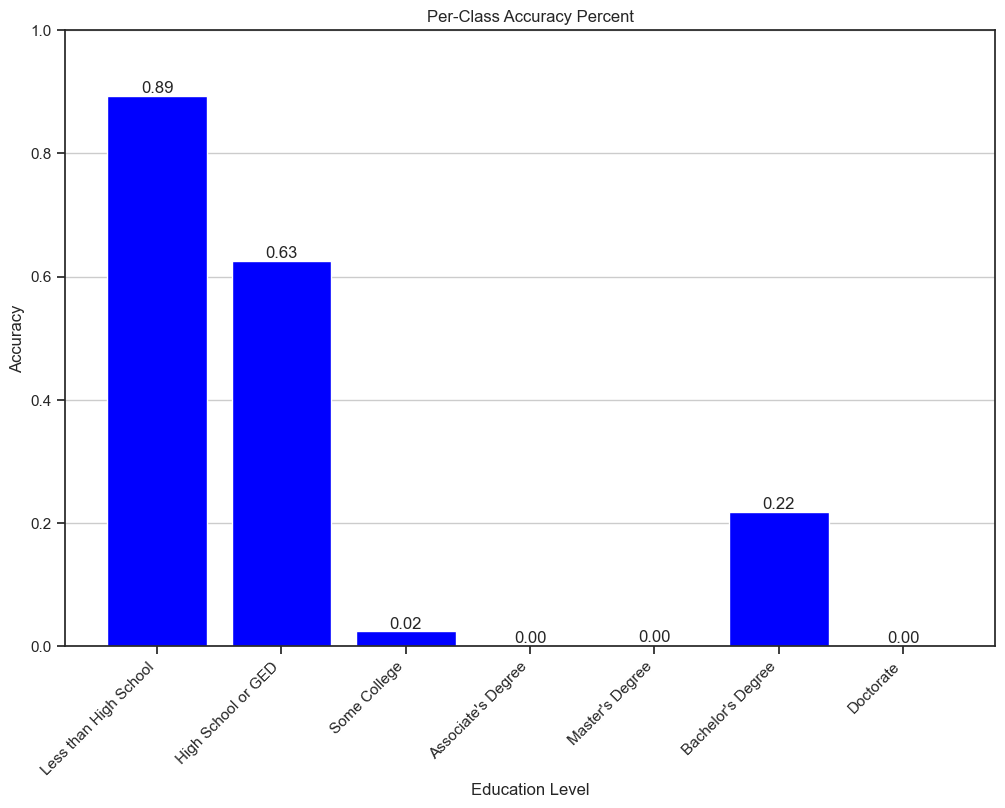

In [37]:
# Function to calculate per-class accuracy from the confusion matrix
def calculate_per_class_accuracy(conf_matrix):
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    return per_class_accuracy

# Calculate per-class accuracy
per_class_accuracy = calculate_per_class_accuracy(conf_matrix)

# Define the education labels
education_labels = {
    0: 'Less than High School',
    1: 'High School or GED',
    2: 'Some College',
    3: "Associate's Degree",
    4: "Master's Degree",
    5: "Bachelor's Degree",
    6: 'Doctorate'
}

# Map the numeric labels to the corresponding education labels
mapped_labels = [education_labels[label] for label in sorted(education_labels.keys())]

# Plot per-class accuracy with education labels
plt.figure(figsize=(12, 8))
plt.bar(mapped_labels, per_class_accuracy, color='blue')
plt.xlabel('Education Level')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Percent')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.grid(axis='y')

# Add accuracy values on top of bars
for i in range(len(mapped_labels)):
    plt.text(i, per_class_accuracy[i], f'{per_class_accuracy[i]:.2f}', ha='center', va='bottom')

plt.show()


### Feature expressiveness analysis

In [38]:
# Extract the coefficients from the best logistic regression model
best_lr_model = bestModel.stages[-1]

# Check if the model is binary or multinomial
if best_lr_model.numClasses == 2:
    # For binary classification
    coefficients = best_lr_model.coefficients.toArray()
    intercept = best_lr_model.intercept
else:
    # For multinomial classification
    coefficients = best_lr_model.coefficientMatrix.toArray()
    intercept = best_lr_model.interceptVector.toArray()

# Aggregate coefficients
if best_lr_model.numClasses == 2:
    # For binary classification, use coefficients directly
    feature_coefficients = {feature: coef for feature, coef in zip(feature_columns, coefficients)}
else:
    # For multinomial classification, aggregate coefficients
    # Here we take the mean of the absolute values of the coefficients across all classes
    aggregated_coefficients = np.mean(np.abs(coefficients), axis=0)
    feature_coefficients = {feature: float(coef) for feature, coef in zip(feature_columns, aggregated_coefficients)}

# Print the coefficients
print("Intercept:", intercept)
print("Aggregated Coefficients for each feature:")
for feature, coef in feature_coefficients.items():
    print(f"{feature}: {coef}")


Intercept: [0. 0. 0. 0. 0. 0. 0.]
Aggregated Coefficients for each feature:
WorkClassIndexed: 0.02575038451118069
MaritalStatusIndexed: 0.01935246385312129
OccupationIndexed: 0.025699321994363363
RelationshipIndexed: 0.02657585139091482
RaceIndexed: 0.05414402733804837
SexIndexed: 0.06645888029369372
NativeCountryIndexed: 0.009626341210160075
IncomeIndexed: 0.1557899874706026
AgeScaled: 0.07831047792752267
FnlwgtScaled: 0.08094676375831941
EducationNumScaled: 0.1269181911318687
CapitalGainScaled: 0.057711029966528896
CapitalLossScaled: 0.1981448183762235
HoursPerWeekScaled: 0.06358034921610056


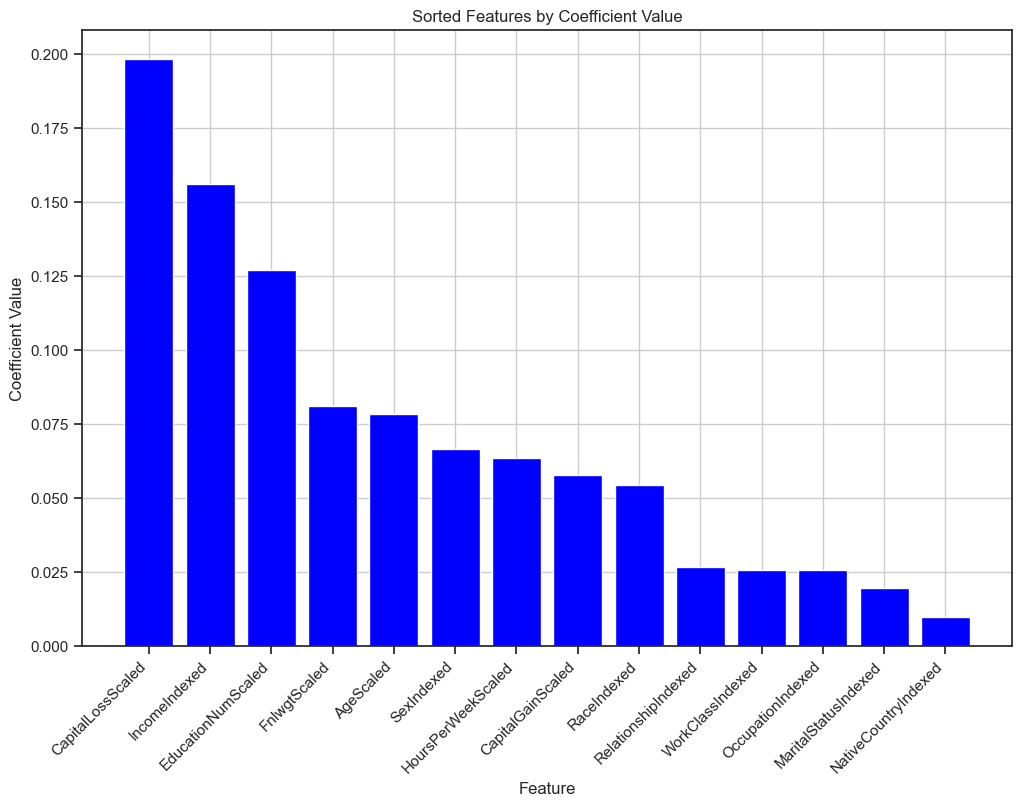

In [39]:
sorted_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names = [feature for feature, coef in sorted_features]
sorted_coefficients = [coef for feature, coef in sorted_features]

# Plot the sorted features with their coefficients
plt.figure(figsize=(12, 8))
plt.bar(sorted_feature_names, sorted_coefficients, color='blue')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Sorted Features by Coefficient Value')
plt.xticks(rotation=45, ha='right')  # Rotate the feature names for better readability
plt.grid(True)

In [40]:
# Evaluate model performance using top N features
num_features_list = range(1, len(sorted_feature_names) + 1)
train_accuracy_list = []
validation_accuracy_list = []
test_accuracy_list = []

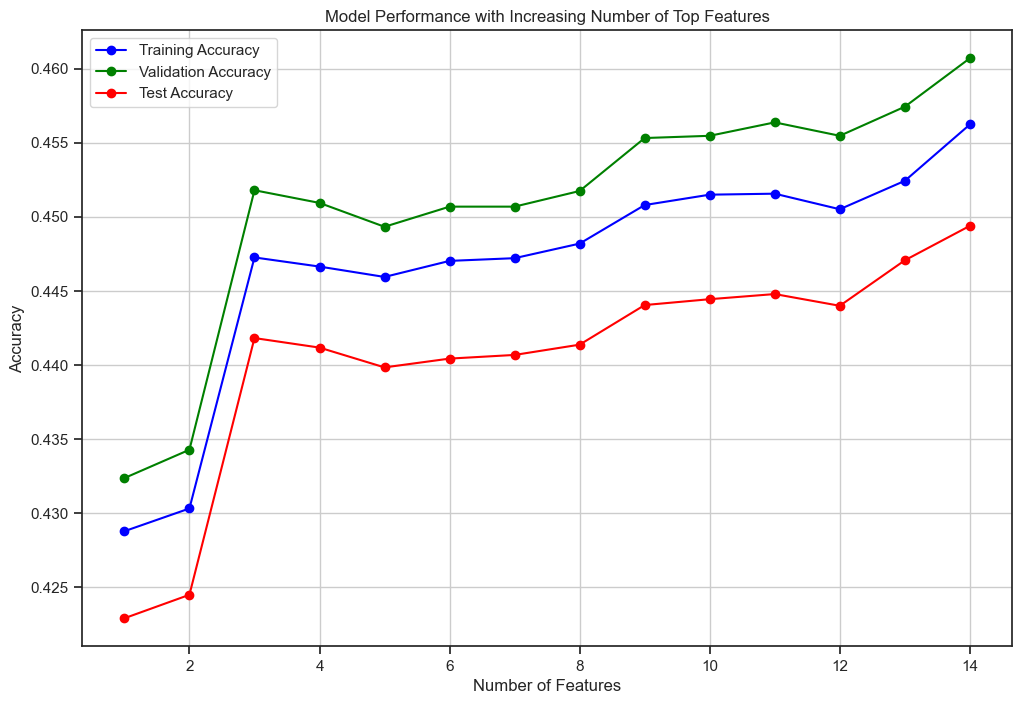

In [41]:
for num_features in num_features_list:
    top_features = sorted_feature_names[:num_features]
    
    # Define VectorAssembler to assemble top features into a single vector column
    vector_assembler = VectorAssembler(inputCols=top_features, outputCol='features')
    
    # Create Logistic Regression model
    lr = LogisticRegression(featuresCol='features', labelCol=label_column)
    
    # Create a pipeline with VectorAssembler and Logistic Regression model
    pipeline = Pipeline(stages=[vector_assembler, lr])
    
    # Fit the model to the training data
    model = pipeline.fit(train)
    
    # Evaluate the model on the training data
    train_predictions = model.transform(train)
    train_accuracy = evaluator.evaluate(train_predictions)
    train_accuracy_list.append(train_accuracy)
    
    # Evaluate the model on the validation data
    validation_predictions = model.transform(validation)
    validation_accuracy = evaluator.evaluate(validation_predictions)
    validation_accuracy_list.append(validation_accuracy)
    
    # Evaluate the model on the test data
    test_predictions = model.transform(test)
    test_accuracy = evaluator.evaluate(test_predictions)
    test_accuracy_list.append(test_accuracy)

# Plot the performance
plt.figure(figsize=(12, 8))
plt.plot(num_features_list, train_accuracy_list, marker='o', color='blue', label='Training Accuracy')
plt.plot(num_features_list, validation_accuracy_list, marker='o', color='green', label='Validation Accuracy')
plt.plot(num_features_list, test_accuracy_list, marker='o', color='red', label='Test Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Model Performance with Increasing Number of Top Features')
plt.legend()
plt.grid(True)
plt.show()

### Fitting Graph

In [43]:
# Convert Spark DataFrame to NumPy arrays for Scikit-Learn
X_train_np = np.array(train.select(feature_columns).collect())
y_train_np = np.array(train.select(label_column).collect()).ravel()

X_validation_np = np.array(validation.select(feature_columns).collect())
y_validation_np = np.array(validation.select(label_column).collect()).ravel()

X_test_np = np.array(test.select(feature_columns).collect())
y_test_np = np.array(test.select(label_column).collect()).ravel()

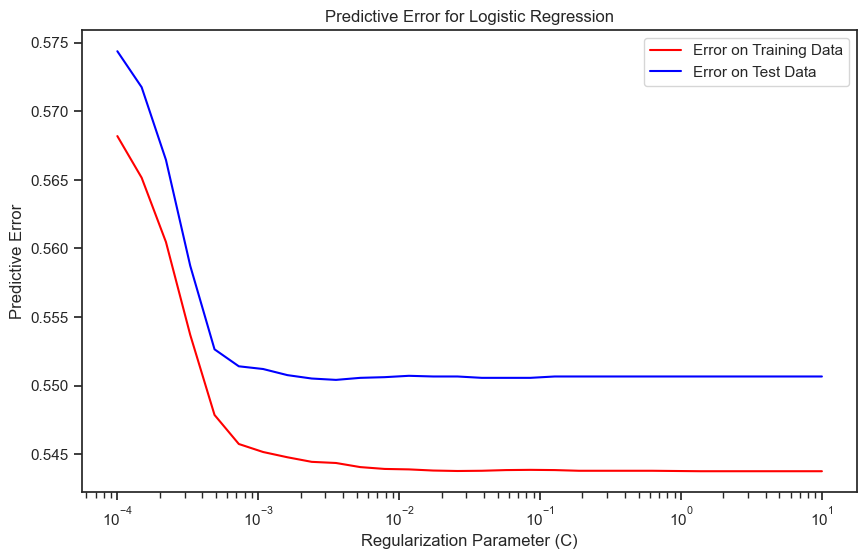

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming X_train, y_train, X_test, and y_test are already defined
# If not, you need to split your data into training and test sets

# Standardize the features
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

# Define a range of regularization parameters (inverse of regularization strength)
C_values = np.logspace(-4, 1, 30)

# Lists to store errors
train_errors = []
test_errors = []

# Iterate over different values of C
for C in C_values:
    lr = LogisticRegression(C=C, max_iter=10000)
    
    # Fit the logistic regression model
    lr.fit(X_train_np, y_train_np)
    
    # Predict on training data
    train_predictions = lr.predict(X_train_np)
    train_error = 1 - accuracy_score(y_train_np, train_predictions)
    train_errors.append(train_error)
    
    # Predict on test data
    test_predictions = lr.predict(X_test_np)
    test_error = 1 - accuracy_score(y_test_np, test_predictions)
    test_errors.append(test_error)

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors, label='Error on Training Data', color='red')
plt.plot(C_values, test_errors, label='Error on Test Data', color='blue')

# Add labels and title
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Predictive Error')
plt.title('Predictive Error for Logistic Regression')

# Set the scale of x-axis to logarithmic
plt.xscale('log')

# Add legend
plt.legend()

# Show the plot
plt.show()


## Random Forest Model

In [45]:
from pyspark.ml.classification import RandomForestClassifier

# Define VectorAssembler to assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Create Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol=label_column, maxBins=64)

# Create a pipeline with VectorAssembler and Logistic Regression model
pipeline = Pipeline(stages=[vector_assembler, rf])

# Fit the pipeline to the training data
model = pipeline.fit(train)

In [46]:
# Compute accuracy for training set
train_predictions = model.transform(train)
train_accuracy = evaluator.evaluate(train_predictions)

# Compute accuracy for validation set
validation_predictions = model.transform(validation)
validation_accuracy = evaluator.evaluate(validation_predictions)

# Make predictions on the test set
test_predictions = model.transform(test)
accuracy = evaluator.evaluate(test_predictions)

# Print accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", accuracy)

Training Accuracy: 0.6024890312463507
Validation Accuracy: 0.6027286915370287
Test Accuracy: 0.6015153015747252


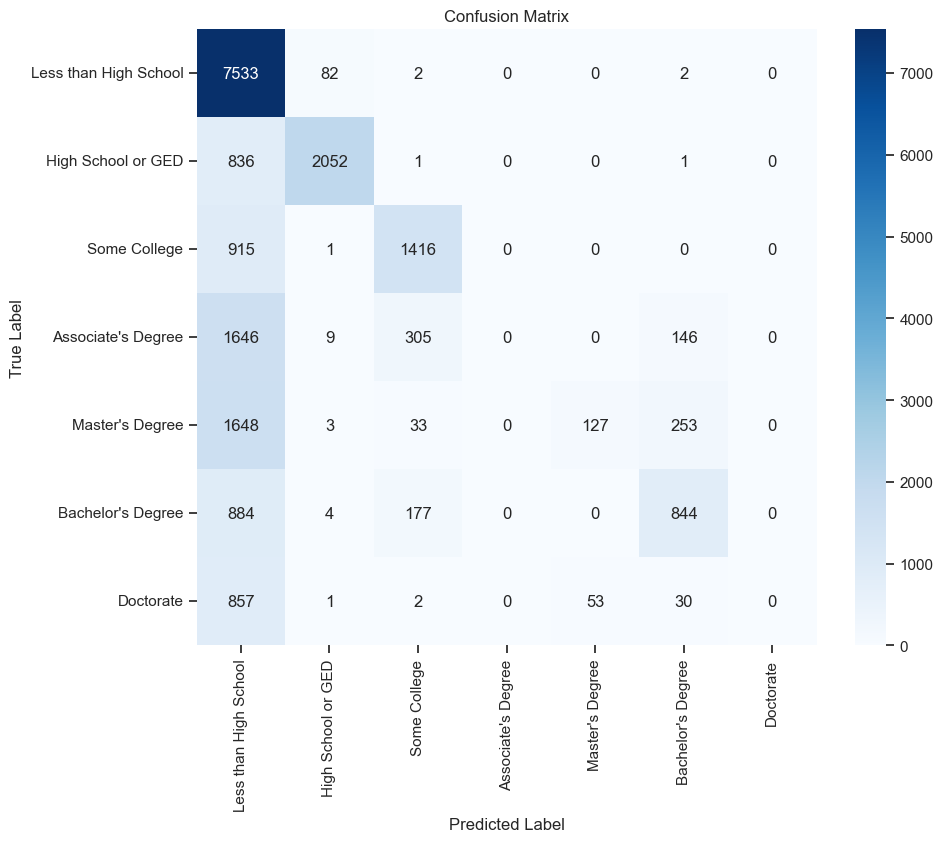

In [47]:
from sklearn.metrics import confusion_matrix

# Extract true and predicted labels from validation predictions
y_true = validation_predictions.select('EducationGroupIndexed').collect()
y_pred = validation_predictions.select('prediction').collect()

# Convert Spark DataFrame rows to lists
y_true = [row['EducationGroupIndexed'] for row in y_true]
y_pred = [row['prediction'] for row in y_pred]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=education_labels.values(), yticklabels=education_labels.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Fitting Graph

In [ ]:
# Create an evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=label_column, metricName="accuracy")

# Lists to store errors
training_errors = []
validation_errors = []
test_errors = []
model_complexities = []

# Define the range for model complexity (number of trees in the Random Forest)
num_trees_list = [20, 40, 60, 80, 100]

# Iterate over different values of model complexity
for num_trees in num_trees_list:
    # Create Random Forest model with the current number of trees
    rf = RandomForestClassifier(featuresCol='features', labelCol=label_column, numTrees=num_trees, maxBins=64)
    
    # Create a pipeline with VectorAssembler and Random Forest model
    pipeline = Pipeline(stages=[vector_assembler, rf])
    
    # Fit the pipeline to the training data
    model = pipeline.fit(train)
    
    # Compute accuracy for training set
    train_predictions = model.transform(train)
    train_accuracy = evaluator.evaluate(train_predictions)
    train_error = 1 - train_accuracy
    training_errors.append(train_error)
    
    # Compute accuracy for validation set
    validation_predictions = model.transform(validation)
    validation_accuracy = evaluator.evaluate(validation_predictions)
    validation_error = 1 - validation_accuracy
    validation_errors.append(validation_error)
    
    # Make predictions on the test set
    test_predictions = model.transform(test)
    test_accuracy = evaluator.evaluate(test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
    
    # Store the current model complexity
    model_complexities.append(num_trees)

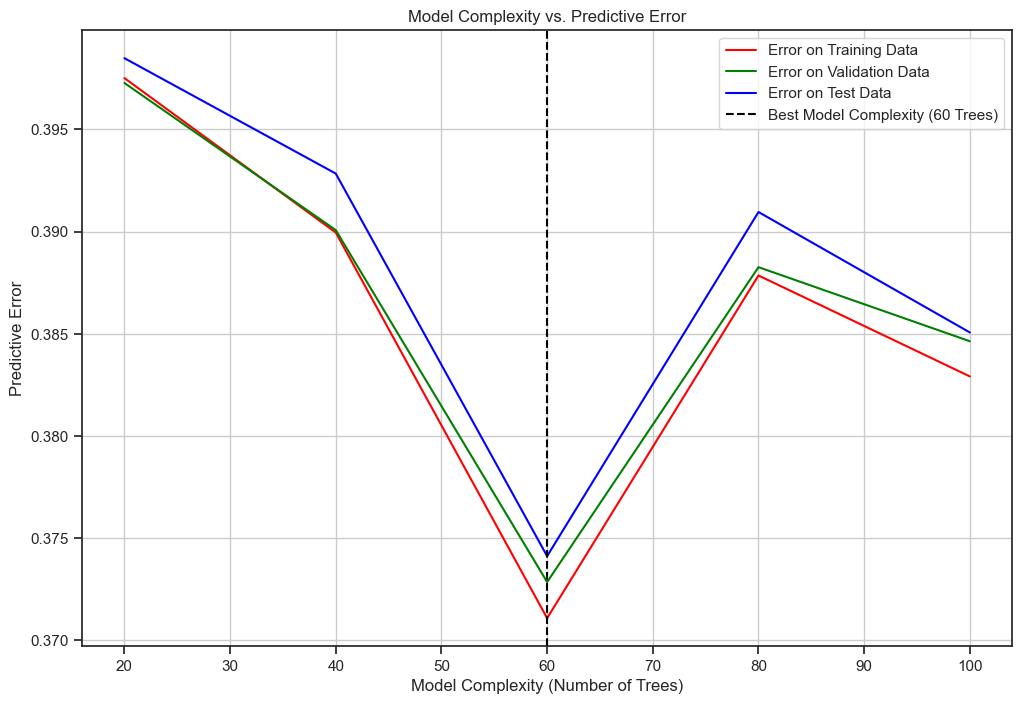

In [57]:
# Plot the final errors against model complexity
plt.figure(figsize=(12, 8))
plt.plot(model_complexities, training_errors, label='Error on Training Data', color='red')
plt.plot(model_complexities, validation_errors, label='Error on Validation Data', color='green')
plt.plot(model_complexities, test_errors, label='Error on Test Data', color='blue')
plt.axvline(x=best_num_trees, color='black', linestyle='--', label=f'Best Model Complexity ({best_num_trees} Trees)')

# Add labels and title
plt.xlabel('Model Complexity (Number of Trees)')
plt.ylabel('Predictive Error')
plt.title('Model Complexity vs. Predictive Error')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Find the best model complexity based on validation accuracy
best_index = np.argmin(validation_errors)
best_num_trees = model_complexities[best_index]

print(f"Best number of trees: {best_num_trees}")

Best number of trees: 60


In [56]:
# Train the final model using the best number of trees
rf = RandomForestClassifier(featuresCol='features', labelCol=label_column, numTrees=best_num_trees, maxBins=64)
pipeline = Pipeline(stages=[vector_assembler, rf])
final_model = pipeline.fit(train)

# Compute accuracy for training set
final_train_predictions = final_model.transform(train)
final_train_accuracy = evaluator.evaluate(final_train_predictions)
final_train_error = 1 - final_train_accuracy

# Compute accuracy for validation set
final_validation_predictions = final_model.transform(validation)
final_validation_accuracy = evaluator.evaluate(final_validation_predictions)
final_validation_error = 1 - final_validation_accuracy

# Make predictions on the test set
final_test_predictions = final_model.transform(test)
final_test_accuracy = evaluator.evaluate(final_test_predictions)
final_test_error = 1 - final_test_accuracy

# Print final accuracies
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)
print("Final Test Accuracy:", final_test_accuracy)


Final Training Accuracy: 0.6289141350950069
Final Validation Accuracy: 0.6271459497558274
Final Test Accuracy: 0.6258789739526592


### Data Download and Requirements

- Data can be downloaded off : https://www.kaggle.com/datasets/brijeshbmehta/adult-datasets